# Neural Networks for Classification

This will serve an introduction to `keras`, `tensorflow`, and the basics of neural networks. It will walk through the current eNable framework for the classification of EMG. So let's get to it.

## First thing first, what you'll need...
0. [Git](https://git-scm.com/)  

  Git is optional, but it is an excellent tool to use. I will not be covering it in depth here, since the goal for this guide is the neural network, but I would recommend anyone wanting to get into coding to learn how to use this tool. At this [link](https://www.lynda.com/Git-tutorials/Git-Essential-Training/100222-2.html?srchtrk=index%3a1%0alinktypeid%3a2%0aq%3agit%0apage%3a1%0as%3arelevance%0asa%3atrue%0aproducttypeid%3a2) you can find a very useful overview of some of the git commands and practices. Sections 5-7 give the basic overview, but the whole course itself is really good.

  
1. A Python IDE such as [spyder](https://pythonhosted.org/spyder/installation.html) (my personal favorite), [PyCharm](https://www.jetbrains.com/pycharm/), or anything you'd like.

  
2. [Python 3.6](https://www.python.org/downloads/)

  With this, the `pip` installer should have been created which can be used to install additional packages using the command line. It can be utilized either through the Windows Command Prompt, or through Git Bash (assuming git was installed as above).

  
3. Run `pip install -r requirements.txt` using the command line in the folder containing this jupyter notebook and the other python files

  * This will begin the process of installing all of the required packages:
    1. `Tensorflow` for the backend
    2. `keras` to make Tensorflow easier to use
    3. `SciPy` contains a couple useful mathematical tools
    4. `Matplotlib` package to plot the results of the analysis 
    5. `PyWavelets` takes the raw EMG data and transforms it into wavelet form
    6. `Scikit-learn` contains yet more useful mathematical functions
    7. `jupyter` which makes this document usable

  
4. Download the `wavelet_data.pkl` file from this Google drive [link](https://drive.google.com/open?id=0B8xHGc-boVGNbGVfdlRMdk9VNHM)

## The framework
### Package and function import

The required files from both the `keras` package and `nn_analysis_funcs.py` which contains some useful functions for setting up the analysis to keep the `run_analysis_nn.py` clean.

In [1]:
from nn_analysis_funcs import (import_data, pre_process_data,
                               show_confusion_matrix, find_confusion_matrix,
                               show_learning, generator)
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from math import floor
from new_network_structure import def_NN_architecture

C:\Users\jason\Anaconda3n\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define network architecture

The structure of the neural net is defined in `functional_NN_EMG.py` as the function `define_NN_architecture`. The function takes no input and returns the model. It is imported into the program with the following line of code. If you want to change the structure of the neural net into something of your own, editing `define_NN_architecture.py` is the way to go. The neural network data is imported from the `.pkl` file (python version of `.mat` file essentially). The data is then split up into `train_data_x` (the wavelet data), `train_data_x_rms` (root mean square for each of the 16 channels of the EMG), and `train_data_y` (the label assigned to each run).

In [3]:
nn_data = import_data('full_data.pkl')
(train_data_x, train_data_x_rms, train_data_x_emg, train_data_y) = pre_process_data(nn_data)
model = def_NN_architecture()

## Set up feeding the training data using generators

There is one issue with the data in its raw format: it's too big. The data itself takes up more than 1 GB in its raw form. This leads an issue with the memory when the network is trying to train the millions of parameters needed for the network. Instead then of using the raw data, we use a generator instead (see `generator` in `nn_analysis_funcs.py` for how this functions is built and [this link](https://wiki.python.org/moin/Generators) for what a generator is in python). This prevents the entire data from being loaded into memory and is instead fed piecemeal into the fitting process.

The neural network itself trains of 70% of the data, seeing how the updated weights affect the classification of the entire data set. The neural network, once it runs through the entire training set, will test those weights on a separate data set, the validation set. This set makes sure that the learning of the dataset is actually generalizable to a separate data set. Finally, the testing set verifies how the fully trained model deals with data it has never seen before.

Finally, the parameter batch_size (in `run_NN_analysis.py` it is passed as a parameter into the `main` function), specifies how much of the data set to load into at once. This is highly dependent on your system. You can play around with this value to whatever seems to result in the fastest training.

In [4]:
batch_size = 16

train_step_length = int(0.7*len(train_data_y))
val_length = int(0.2*len(train_data_y))
test_length = int(0.1*len(train_data_y))

train_gen = generator(train_data_x, train_data_x_rms, train_data_x_emg,
                      train_data_y, batch_size,
                      0, train_step_length)

val_gen = generator(train_data_x, train_data_x_rms, train_data_x_emg,
                    train_data_y, batch_size,
                    train_step_length + 1, train_step_length + val_length)

## Define the model training

First, the optimizer is defined that the model will use. In this case, I've chosen the Adadelta algorithm. There are many other built-in to keras. See [here](https://keras.io/optimizers/) for more details.

Since the model uses categorical labels for data, and each run is only assigned one label, the loss function is `cateogrical_crossentropy`, where the metric we are interested in is the accuracy of the run.

The additional checkpoint function is merely a method to save the best model over all the tested epochs (iterations over the full data set).

The `train_step_num` and the `val_step_num` have to be calculated for the model fit, and are automatically done by the program.

In [5]:
adadelta_optim = Adadelta(lr=1, rho=0.95, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=adadelta_optim,
              metrics=['accuracy'])

checkpoint_func = ModelCheckpoint('best_model.hdf5',
                                  monitor='val_acc',
                                  save_best_only=True,
                                  mode='max')

train_step_num = floor(train_step_length/batch_size)
val_step_num = floor(val_length/batch_size)

## The pièce de résistance... running the fit

These lines of code actually set up the fit of the neural network. The generators are imported, the number of steps needed to perform for each epoch, the number of epochs to run the model (35-50 is usually the amount it takes before the validation accuracy plateaus), the validation generator, the number of validation steps, and then adding in the callback function into the model fit.

**This step will take quite a while. 8 hours running on a CPU is quite realistic and it could take even longer depending on model complexity. This is why GPU computation has been incredibly useful for neural networks (and outside the scope of this guide).**

In [6]:
hist = model.fit_generator(train_gen,
                           steps_per_epoch=train_step_num,
                           epochs=1,
                           validation_data=val_gen,
                           validation_steps=val_step_num,
                           callbacks=[checkpoint_func])


Epoch 1/1
717/717 [==============================] - 969s 1s/step - loss: 2.7784 - acc: 0.1769 - val_loss: 2.4909 - val_acc: 0.2598


## Summarizing the model

A confusion matrix is a matrix showing the model labeling versus the true labeling of the data. Note: the matrix visualization does not render well in the cells below, but works well in a separate window.

Confusion matrix, without normalization
[[132   0   0   0   0   0   0   1   0   0   0   1   1   2   0   0   2   1]
 [ 38  41   0   0   0   0   0   8   0   5   0   0   0   2   0   0  13   3]
 [ 23   3   0   0   0   1   1  16   0   3   0   0   4   1   0   6  38   1]
 [  8   7   0   0   0   1   1   3   0   2   0   3   0   0   0   0  53   8]
 [ 18   4   0   0   0   2   0   5   0   1   0   2   0   5   0  14  32   1]
 [ 16   3   0   0   0   1   0   1   0   1   0   2   1   2   0  11  37   3]
 [  9   3   0   0   0   0   0   8   0   4   0   0   0   0   0   1  43   3]
 [ 26  18   0   0   0   2   0  19   0   1   0   1   0   2   0   1   5   2]
 [ 18   2   0   0   0   1   0   3   0   1   0   2   1   5   0   4  40   5]
 [ 23   1   0   0   0   1   0   0   0   5  12  14   1   1   0   8  17   4]
 [  7   0   0   0   0   1   0   0   0   5   9   3   2   1   0   7  36   2]
 [ 29   5   0   0   0   2   0   4   0   1   2  11   2   2   0   4  22   7]
 [ 18  10   0   0   0   1   0   1   0   0   0   2   1   3   

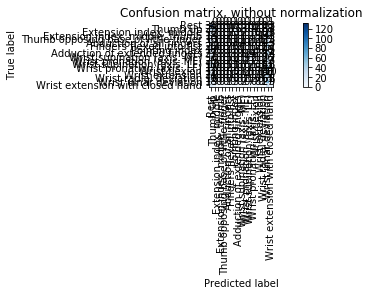

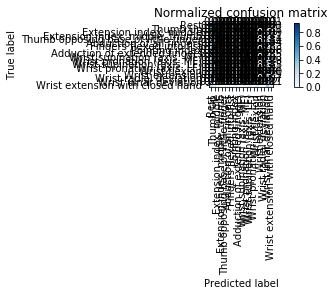

NameError: name 'hist' is not defined

In [6]:
conf_matrix = find_confusion_matrix(model,
                                    [train_data_x[-test_length:],
                                    train_data_x_rms[-test_length:]
                                    train_data_x_emg[-test_length:]                                    ],
                                    train_data_y[-test_length:])
show_confusion_matrix(conf_matrix)
show_learning(hist)

## That's it!

You just finished training a neural net!